In [95]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, precision_score,recall_score
import itertools
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [3]:
data = pd.read_csv('core/cleveland.csv')

In [4]:
data.num = data.num.apply(lambda x: 1 if x >0 else 0)

In [5]:
feature_list = data.columns[:-1]

In [6]:
feature_list

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [7]:
combinations = []
for r in range(4, len(feature_list) + 1):
    combinations.extend(itertools.combinations(feature_list, r))

combinations = [list(combo) for combo in combinations]

In [8]:
data_filtered=data.replace('?',pd.NA)

In [9]:
data_filtered = data_filtered.dropna()

In [10]:
features=data_filtered.corr()[['num']].apply(lambda x: abs(x)).sort_values('num',ascending=False).index[1:]

In [11]:
features

Index(['thal', 'ca', 'oldpeak', 'thalach', 'exang', 'cp', 'slope', 'sex',
       'age', 'restecg', 'trestbps', 'chol', 'fbs'],
      dtype='object')

In [12]:
class CustomKNeighbors(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.nn.fit(X)
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        distances, indices = self.nn.kneighbors(X)
        predictions = []
        for idx in indices:
            neighbor_labels = self.y_train[idx]
            predicted_value = np.median(neighbor_labels)  # Calculate the median
            
            # Adjust the prediction based on the median value
            if predicted_value == 0.5:
                predictions.append(1)  # If median is 0.5, predict 1
            else:
                predictions.append(predicted_value)  # Otherwise, use the median
        return np.array(predictions)


In [13]:
results = []

feature_indices = {
    tuple(feature_combination): [data_filtered.columns.get_loc(col) for col in feature_combination]
    for feature_combination in combinations
}


X = data_filtered.drop(columns='num').values
y = data_filtered['num'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'n_neighbors': np.arange(1, 21, 2)}
f1_scorer = make_scorer(f1_score, average='weighted', greater_is_better=True)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for feature_combination, indices in feature_indices.items():
    X_train_subset = X_train_scaled[:, indices]
    X_test_subset = X_test_scaled[:, indices]

    custom_knn = CustomKNeighbors(n_neighbors=5)

    grid_search = GridSearchCV(custom_knn, param_grid, cv=skf, scoring=f1_scorer, verbose=1)
    grid_search.fit(X_train_subset, y_train)

    best_model = grid_search.best_estimator_

    results.append({
        'feature_combination': feature_combination,
        'best_n_neighbors': grid_search.best_params_['n_neighbors'],
        'best_cv_score': grid_search.best_score_,
    })

knn_results = pd.DataFrame(results)
knn_results.to_csv('Knn_Results1.csv')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 1

In [104]:
knn_results = pd.read_csv('Knn_Results1.csv')
best_feature = list(ast.literal_eval(knn_results.iloc[knn_results.best_cv_score.idxmax()].feature_combination))

In [143]:
X = data_filtered[best_feature].values
y = data_filtered['num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'n_neighbors': np.arange(1, 21, 1)}
f1_scorer = make_scorer(f1_score, average='weighted', greater_is_better=True,)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42 )
custom_knn = CustomKNeighbors(n_neighbors=5)
grid_search = GridSearchCV(custom_knn, param_grid, cv=skf, scoring=f1_scorer, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

print(f'best_n_neighbors: {grid_search.best_params_["n_neighbors"]}, ' f'best_cv_score: {grid_search.best_score_}')


Fitting 10 folds for each of 20 candidates, totalling 200 fits
best_n_neighbors: 17, best_cv_score: 0.8548426116076765


In [144]:
score_results = pd.DataFrame(grid_search.cv_results_)

([<matplotlib.axis.XTick at 0x256d1e61cd0>,
 [Text(1, 0, '1'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(9, 0, '9'),
  Text(11, 0, '11'),
  Text(13, 0, '13'),
  Text(15, 0, '15'),
  Text(17, 0, '17'),
  Text(19, 0, '19')])

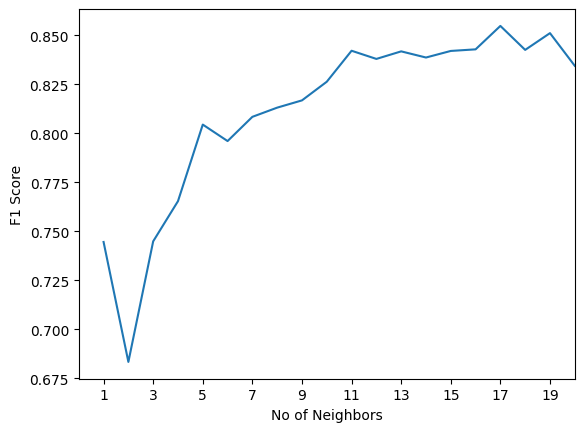

In [146]:
sns.lineplot(data = score_results, x = 'param_n_neighbors', y ='mean_test_score')
plt.xlabel('No of Neighbors')
plt.ylabel('F1 Score')
plt.xlim(0,20)
plt.xticks(range(1, 21, 2))

In [147]:
y_pred = best_model.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print the results
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1 Score: 0.8641
Precision: 0.8700
Recall: 0.8667


In [ ]:
sample_data = pd.read_csv('core/cleveland-test-sample.csv')
sample_data.replace('?', pd.NA, inplace=True)
sample_data.dropna(inplace=True)
sample_data.drop(Unnamed: 0',inplace=True, axis=1)

In [149]:
sample_data.drop(Unnamed: 0',inplace=True, axis=1)

In [150]:
sample_data_X = sample_data.drop('disease', axis=1)[best_feature].values

In [151]:
sample_data_y = sample_data.disease.values

In [152]:
sample_data_Xscaled = scaler.transform(sample_data_X)

In [153]:
sampe_data_ypredict=best_model.predict(sample_data_Xscaled)

In [154]:
f1 = f1_score(sample_data_y, sampe_data_ypredict, average='weighted')
precision = precision_score(sample_data_y, sampe_data_ypredict, average='weighted')
recall = recall_score(sample_data_y, sampe_data_ypredict, average='weighted')

# Print the results
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1 Score: 0.9229
Precision: 0.9239
Recall: 0.9231
